
# 🌼 제너레이티브AI의 이해 - 2차시(24.11.19)

---


## 1. GAN
- 생성자와 판별자 두 가지 모델이 서로 경쟁하며 학습하는 방식
- 생성자 : 랜덤한 잠재 벡터를 입력받아, 이를 기반으로 새로운 데이터 생성
- 판별자 : 생성된 데이터가 진짜인지 가짜인지 판별

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(42)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 음수와 양수 값을 모두 다룰 수 있기 때문에 데이터 다루기에 용이

mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

In [3]:
example_data, example_label = next(iter(data_loader))

In [4]:
print(f'첫 번째 데이터의 shape: {example_data.shape}')
# 배치 크기, 채널, 높이, 너비

첫 번째 데이터의 shape: torch.Size([64, 1, 28, 28])


In [6]:
print(f'첫 번재 데이터의 라벨: {example_label[0]}')

첫 번재 데이터의 라벨: 5


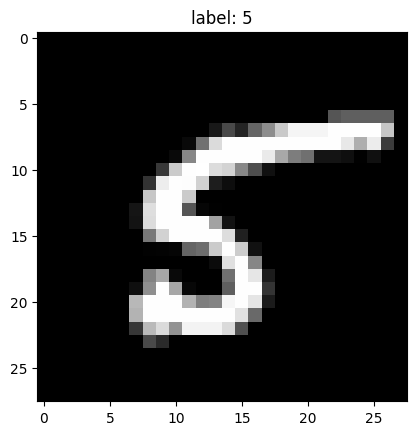

In [7]:
plt.imshow(example_data[0].squeeze(), cmap='gray')
plt.title(f'label: {example_label[0].item()}')
plt.show()

In [8]:
input_size = 100  # 너무 크면 과적합 될 수 있음
hidden_size_gen1 = 256  # 중간 레이어들의 뉴런 수 (GAN에서는 점점 늘어나는 계층적인 구조를 이룬다)
hidden_size_gen2 = 512
hidden_size_gen3 = 1024
output_size = 28 * 28

In [9]:
# 생성자 레이어 정의
gen_w1 = nn.Parameter(torch.randn(input_size, hidden_size_gen1) * 0.02)
# 첫 번째 가중치: input_size -> hidden_size_gen1으로 변환하는 첫 번째 레이어의 가중치를 랜덤으로 초기화
# 0.02는 가중치 값을 초기화할 때 스케일 조정
gen_b1 = nn.Parameter(torch.zeros(hidden_size_gen1))
# 편향 벡터, 뉴런의 입력 값이 0이어도 출력이 발생할 수 있도록 유연하게 조정

gen_w2 = nn.Parameter(torch.randn(hidden_size_gen1, hidden_size_gen2) * 0.02)
gen_b2 = nn.Parameter(torch.zeros(hidden_size_gen2))

gen_w3 = nn.Parameter(torch.randn(hidden_size_gen2, hidden_size_gen3) * 0.02)
gen_b3 = nn.Parameter(torch.zeros(hidden_size_gen3))

gen_w4 = nn.Parameter(torch.randn(hidden_size_gen3, output_size) * 0.02)
gen_b4 = nn.Parameter(torch.zeros(output_size))

In [10]:
def generator(x):
    x = torch.matmul(x, gen_w1) + gen_b1
    # 입력 벡터 x에 첫 번재 레이어의 가중치인 gen_w1을 곱하고 편향 gen_b1를 더하기
    # 첫 번재 레이어의 출력
    x = torch.relu(x)

    x = torch.matmul(x, gen_w2) + gen_b2
    x = torch.relu(x)

    x = torch.matmul(x, gen_w3) + gen_b3
    x = torch.relu(x)

    x = torch.matmul(x, gen_w4) + gen_b4
    x = torch.tanh(x)
    # 마지막 출력을 -1~1사이 범위로 조정
    return x

In [11]:
# 판별자 정의
input_size_dis = 28 * 28
hidden_size_dis1 = 1024
hidden_size_dis2 = 512
hidden_size_dis3 = 256
output_size_dis = 1

In [12]:
dis_w1 = nn.Parameter(torch.randn(input_size_dis, hidden_size_dis1) * 0.02)
dis_b1 = nn.Parameter(torch.zeros(hidden_size_dis1))

dis_w2 = nn.Parameter(torch.randn(hidden_size_dis1, hidden_size_dis2) * 0.02)
dis_b2 = nn.Parameter(torch.zeros(hidden_size_dis2))

dis_w3 = nn.Parameter(torch.randn(hidden_size_dis2, hidden_size_dis3) * 0.02)
dis_b3 = nn.Parameter(torch.zeros(hidden_size_dis3))

dis_w4 = nn.Parameter(torch.randn(hidden_size_dis3, output_size_dis) * 0.02)
dis_b4 = nn.Parameter(torch.zeros(output_size_dis))

In [13]:
# 판별자 전방 전달
def discriminator(x):
    x = torch.matmul(x, dis_w1) + dis_b1
    x = F.leaky_relu(x, 0.2)
    # 0.2: 음수 구간의 기울기에 곱해줄 작은 값

    x = torch.matmul(x, dis_w2) + dis_b2
    x = F.leaky_relu(x, 0.2)

    x = torch.matmul(x, dis_w3) + dis_b3
    x = F.leaky_relu(x, 0.2)

    x = torch.matmul(x, dis_w4) + dis_b4
    x = torch.sigmoid(x)
    return x
    # 출력이 0과 1 사이 값, 진짜 or 가짜

In [16]:
loss_fn = nn.BCELoss()  # Binary Cross Entropy
lr = 0.0002
gen_params = [gen_w1, gen_b1, gen_w2, gen_b2, gen_w3, gen_b3, gen_w4, gen_b4]
dis_params = [dis_w1, dis_b1, dis_w2, dis_b2, dis_w3, dis_b3, dis_w4, dis_b4]

In [17]:
optimizer_gen = torch.optim.Adam(gen_params, lr=lr)
optimizer_dis = torch.optim.Adam(dis_params, lr=lr)

In [18]:
epochs = 20
for epoch in range(epochs):
    for real_images, _ in data_loader:
        batch_size = real_images.size(0)
        # real images의 첫 번째 차원의 값인 batch size
        real_images = real_images.view(batch_size, -1)
        # 기존에 (64, 1, 28, 28) -> (64, 784)

        real_labels = torch.ones(batch_size, 1)
        # (64, 1) 텐서를 생성해서 전체 요소의 각 값들이 전부 1
        fake_labels = torch.zeros(batch_size, 1)
        # (64, 1) 텐서를 생성해서 전체 요소의 각 값들이 전부 0

        # 생성자 학습 구간
        random_noise = torch.randn(batch_size, input_size)
        fake_images = generator(random_noise)

        # 판별자 학습 구간
        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images)

        loss_real = loss_fn(real_output, real_labels)
        # 실제 이미지에 대한 손실값
        loss_fake = loss_fn(fake_output, fake_labels)
        # 가짜 이미지에 대한 손실값
        loss_dis = loss_real + loss_fake
        # 판별자의 총 손실

        optimizer_dis.zero_grad()
        # 기울기 곗간 전 가중치 초기화
        loss_dis.backward()
        # 역전파를 통한 기울기 계산
        optimizer_dis.step()
        # 기울기 업데이트

        # 생성자가 학습
        random_noise = torch.randn(batch_size, input_size)
        # 랜덤 노이즈 생성
        fake_images = generator(random_noise)
        fake_output = discriminator(fake_images)

        # 생성자 손실 계산 + 가중치 업데이트
        loss_gen = loss_fn(fake_output, real_labels)
        # fake_output: 생성자가 만든 가짜 이미지를 판별자가 판별한 결과
        # real_lables: 진짜 이미지의 라벨
        # 가짜 이미지의 판별 결과 vs 진짜 이미지의 라벨

        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

    print(f'Epoch: {epoch + 1} / {epochs}, Loss D: {loss_dis.item()}, Loss G: {loss_gen.item()}')
    # 판별자 손실이 작은 경우: 모든 가짜를 완벽하게 구분하고 있다는 의미
    # 생성자 손실이 큰 경우: 판별자를 속이기 위한 진전이 없다는 의미

Epoch: 1 / 20, Loss D: 0.3541618585586548, Loss G: 2.1726138591766357
Epoch: 2 / 20, Loss D: 0.24016866087913513, Loss G: 4.343298435211182
Epoch: 3 / 20, Loss D: 0.8972729444503784, Loss G: 6.500575065612793
Epoch: 4 / 20, Loss D: 0.23801420629024506, Loss G: 6.129885673522949
Epoch: 5 / 20, Loss D: 0.3287588953971863, Loss G: 9.508502960205078
Epoch: 6 / 20, Loss D: 0.0067023239098489285, Loss G: 5.234284400939941
Epoch: 7 / 20, Loss D: 0.08931363373994827, Loss G: 4.357615947723389
Epoch: 8 / 20, Loss D: 0.1582915186882019, Loss G: 7.554990291595459
Epoch: 9 / 20, Loss D: 3.961047332268208e-05, Loss G: 11.327078819274902
Epoch: 10 / 20, Loss D: 0.0001393253041896969, Loss G: 9.002958297729492
Epoch: 11 / 20, Loss D: 2.5276738597312942e-05, Loss G: 10.61777400970459
Epoch: 12 / 20, Loss D: 0.0008447295404039323, Loss G: 23.616764068603516
Epoch: 13 / 20, Loss D: 1.8265171092934906e-05, Loss G: 10.91982650756836
Epoch: 14 / 20, Loss D: 1.4737813901335587e-18, Loss G: 41.95839309692383

In [19]:
random_noise = torch.randn(16, input_size)
generated_images = generator(random_noise).view(-1, 1, 28, 28).detach()

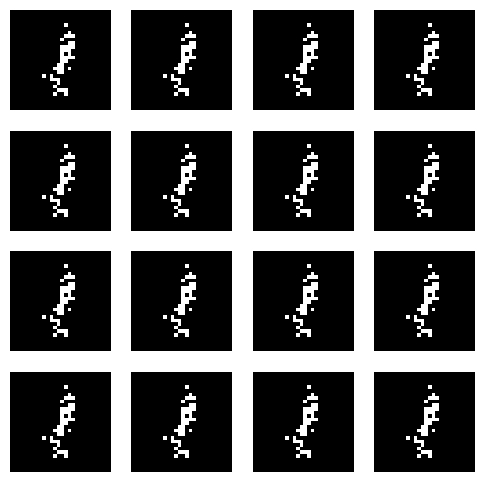

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()


## 🌼마무리 문제

다양한 데이터셋을 적용해보세요

Q1. Fashion MNIST
- 28X28 크기의 패션 아이템 이미지로 구성된 흑백 이미지 데이터셋


Q2. CIFAR-10
- 32X32 크기의 색상이 있는 자동차, 동물 등 다양한 객체가 포함된 데이터셋

In [23]:
trans = transforms.ToTensor()
fashion_mnist_data = datasets.FashionMNIST(root='./data', train=True, transform=trans, download=True)
data_loader = DataLoader(fashion_mnist_data, batch_size=64, shuffle=True)

In [24]:
edata, elabel = next(iter(data_loader))
print(f'첫 번째 데이터의 shape: {edata.shape}')

첫 번째 데이터의 shape: torch.Size([64, 1, 28, 28])


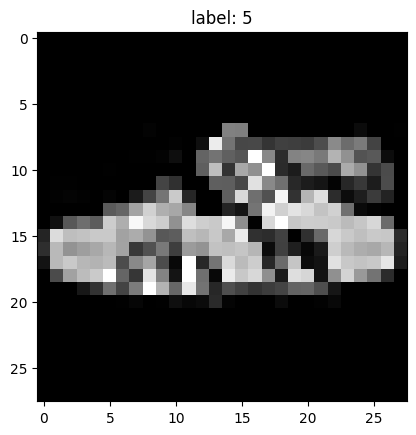

In [25]:
plt.imshow(edata[0].squeeze(), cmap='gray')
plt.title(f'label: {example_label[0].item()}')
plt.show()

In [54]:
input_size = 180 
hidden_size_gen1 = 256 
hidden_size_gen2 = 512
hidden_size_gen3 = 1024
output_size = 28 * 28

gen_w1 = nn.Parameter(torch.randn(input_size, hidden_size_gen1) * 0.02)
gen_b1 = nn.Parameter(torch.zeros(hidden_size_gen1))

gen_w2 = nn.Parameter(torch.randn(hidden_size_gen1, hidden_size_gen2) * 0.02)
gen_b2 = nn.Parameter(torch.zeros(hidden_size_gen2))

gen_w3 = nn.Parameter(torch.randn(hidden_size_gen2, hidden_size_gen3) * 0.02)
gen_b3 = nn.Parameter(torch.zeros(hidden_size_gen3))

gen_w4 = nn.Parameter(torch.randn(hidden_size_gen3, output_size) * 0.02)
gen_b4 = nn.Parameter(torch.zeros(output_size))

In [27]:
def generator(x):
    x = torch.matmul(x, gen_w1) + gen_b1
    x = torch.relu(x)

    x = torch.matmul(x, gen_w2) + gen_b2
    x = torch.relu(x)

    x = torch.matmul(x, gen_w3) + gen_b3
    x = torch.relu(x)

    x = torch.matmul(x, gen_w4) + gen_b4
    x = torch.tanh(x)
    return x

In [28]:
input_size_dis = 28 * 28
hidden_size_dis1 = 1024
hidden_size_dis2 = 512
hidden_size_dis3 = 256
output_size_dis = 1

dis_w1 = nn.Parameter(torch.randn(input_size_dis, hidden_size_dis1) * 0.02)
dis_b1 = nn.Parameter(torch.zeros(hidden_size_dis1))

dis_w2 = nn.Parameter(torch.randn(hidden_size_dis1, hidden_size_dis2) * 0.02)
dis_b2 = nn.Parameter(torch.zeros(hidden_size_dis2))

dis_w3 = nn.Parameter(torch.randn(hidden_size_dis2, hidden_size_dis3) * 0.02)
dis_b3 = nn.Parameter(torch.zeros(hidden_size_dis3))

dis_w4 = nn.Parameter(torch.randn(hidden_size_dis3, output_size_dis) * 0.02)
dis_b4 = nn.Parameter(torch.zeros(output_size_dis))

In [29]:
def discriminator(x):
    x = torch.matmul(x, dis_w1) + dis_b1
    x = F.leaky_relu(x, 0.2)

    x = torch.matmul(x, dis_w2) + dis_b2
    x = F.leaky_relu(x, 0.2)

    x = torch.matmul(x, dis_w3) + dis_b3
    x = F.leaky_relu(x, 0.2)

    x = torch.matmul(x, dis_w4) + dis_b4
    x = torch.sigmoid(x)
    return x

In [42]:
loss_fn = nn.BCELoss()  # Binary Cross Entropy
lr = 0.0002
gen_params = [gen_w1, gen_b1, gen_w2, gen_b2, gen_w3, gen_b3, gen_w4, gen_b4]
dis_params = [dis_w1, dis_b1, dis_w2, dis_b2, dis_w3, dis_b3, dis_w4, dis_b4]

In [37]:
optimizer_gen = torch.optim.Adam(gen_params, lr=lr)
optimizer_dis = torch.optim.Adam(dis_params, lr=lr)

In [55]:
epochs = 5
for epoch in range(epochs):
    for real_images, _ in data_loader:
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1)

        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        random_noise = torch.randn(batch_size, input_size)
        fake_images = generator(random_noise)

        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images)

        loss_real = loss_fn(real_output, real_labels)
        loss_fake = loss_fn(fake_output, fake_labels)
        loss_dis = loss_real + loss_fake

        optimizer_dis.zero_grad()
        loss_dis.backward()
        optimizer_dis.step()

        random_noise = torch.randn(batch_size, input_size)
        fake_images = generator(random_noise)
        fake_output = discriminator(fake_images)

        loss_gen = loss_fn(fake_output, real_labels)

        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

    print(f'Epoch: {epoch + 1} / {epochs}, Loss D: {loss_dis.item()}, Loss G: {loss_gen.item()}')

Epoch: 1 / 5, Loss D: 3.885895338839873e-08, Loss G: 17.806400299072266
Epoch: 2 / 5, Loss D: 1.2636389712383789e-08, Loss G: 18.823427200317383
Epoch: 3 / 5, Loss D: 6.202646396502587e-09, Loss G: 19.062313079833984
Epoch: 4 / 5, Loss D: 3.3948497346614204e-09, Loss G: 19.641387939453125
Epoch: 5 / 5, Loss D: 3.543505711078865e-09, Loss G: 20.05622673034668


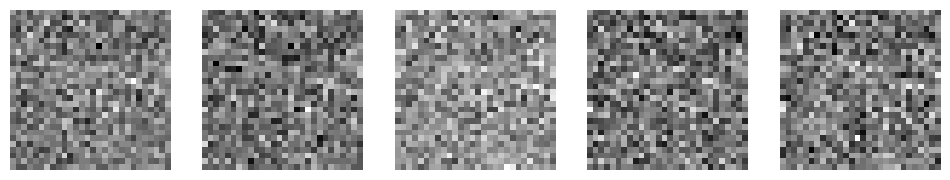

In [56]:
random_noise = torch.randn(5, input_size)
generated_images = generator(random_noise).view(-1, 1, 28, 28).detach()

fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()